In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import numpy as np
import neurospyke as ns
import h5py
from scipy.signal import savgol_filter, butter, lfilter
import os
import preprocessing
import json

In [2]:
f = open('./settings.json')
settings = json.load(f)
f.close()

sampling_frequency = settings['sampling_frequency']
sampling_time = 1 / sampling_frequency
signal_duration = settings['signal_duration']

group = settings['group']
subject = settings['subject']
conditions = settings['conditions']
areas = list(settings['areas'].keys())
areas_labels = [settings['areas'][area]['label'] for area in areas]
n_channels = settings['n_channels']
n_stimuli = settings['n_stimuli']

In [3]:
# Parameters Setting
conditions_idx = 0
areas_idx = 0
channel = 0
channel_labels = ['000', '001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015']
check_transient_idx = 14

In [4]:
# Stimulus Detection
raw_data_paths = preprocessing.get_raw_data_paths(group, subject, conditions[conditions_idx], areas)

stimulus_idxs_matrix = preprocessing.get_stimulus_idxs_matrix(raw_data_paths, conditions[conditions_idx], settings)
stimulus_idxs = preprocessing.get_median_stimulus_idxs(stimulus_idxs_matrix, tolerance_duration=0.1, settings=settings)

In [5]:
# Analysis on a single channel, given the stimulus_idxs computed above
f = h5py.File(os.path.join('./data', group, subject, conditions[conditions_idx], 'Raw_' + areas[areas_idx] +'_Ch_' + channel_labels[channel] + '.mat'))

raw_data = f['data']
raw_data = np.reshape(raw_data, np.size(raw_data))
raw_data = raw_data[np.arange(signal_duration * sampling_frequency)]

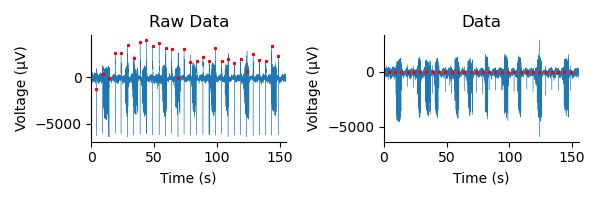

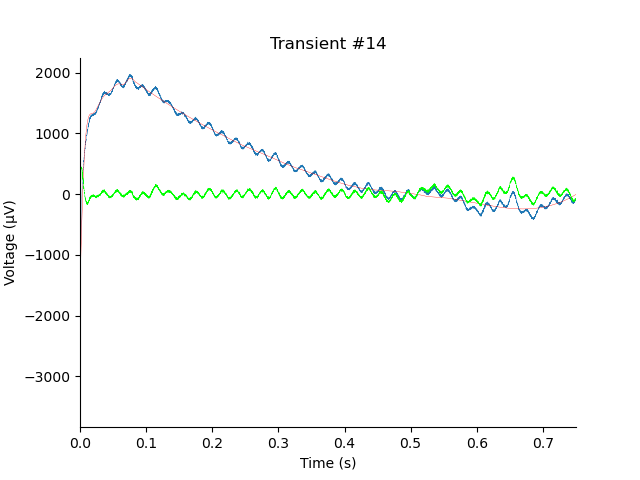

In [6]:
# Stimulus Artifacts Suppression
data = np.copy(raw_data)

fig_data = ns.visualization.pyplot.figure(figsize=[6, 2])
gs = ns.visualization.pyplot.GridSpec(1, 2)
ax0 = fig_data.add_subplot(gs[0, 0])
ax1 = fig_data.add_subplot(gs[0, 1])

ns.visualization.plot_spikes(data, stimulus_idxs, ax=ax0, sampling_time=sampling_time, title='Raw Data')

stimulus_duration = 0.002 # seconds
stimulus_samples = int(np.round(stimulus_duration * sampling_frequency))
stimulus_half_samples = int(np.ceil(stimulus_samples / 2))
stimulus_range = np.arange(-stimulus_half_samples, stimulus_half_samples)

transient_duration = 0.75 # seconds
transient_samples = int(np.ceil(transient_duration * sampling_frequency))
transient_range = np.arange(stimulus_half_samples, stimulus_half_samples + transient_samples)

for idx in np.arange(np.size(stimulus_idxs)):
    stimulus_idx = stimulus_idxs[idx]
    data[stimulus_idx + stimulus_range] = 0
    transient = data[stimulus_idx + transient_range]

    max_idx = np.argmax(transient)
    # Ensure a meaningful max_idx, otherwhise set it null
    max_idx = max_idx[0] if type(max_idx) == np.ndarray else max_idx
    max_idx = 0 if max_idx < 100 else max_idx
    max_idx = np.size(transient) if np.abs(np.size(transient) - max_idx) < 100 else max_idx

    transient_smoothed = np.zeros(np.shape(transient))

    if max_idx != 0:
        left_transient_range = np.arange(stimulus_half_samples, stimulus_half_samples + max_idx) - stimulus_half_samples
        window_length =  int(np.floor(np.size(left_transient_range) / 5) * 2 + 1) # force odd length
        transient_smoothed[left_transient_range] = savgol_filter(transient[left_transient_range], window_length, 3)

    if max_idx != np.size(transient):
        right_transient_range = transient_range[max_idx:] - stimulus_half_samples
        window_length =  int(np.floor(np.size(right_transient_range) / 5) * 2 + 1) # force odd length
        transient_smoothed[right_transient_range] = savgol_filter(transient[right_transient_range], window_length, 3)

    transient_smoothed = savgol_filter(transient_smoothed, 501, 3) # remove left-right discontinuity

    data[stimulus_idx + transient_range] = data[stimulus_idx + transient_range] - transient_smoothed

    if idx == check_transient_idx:
        fig = ns.visualization.pyplot.figure()
        ax = fig.add_subplot(1, 1, 1)

        ns.visualization.plot_raw_data(transient, ax=ax, sampling_time=sampling_time)
        ns.visualization.plot_raw_data(transient_smoothed, ax=ax, sampling_time=sampling_time, color='#FF0000')
        ns.visualization.plot_raw_data(transient - transient_smoothed, ax=ax, sampling_time=sampling_time, color='#00FF00', title='Transient #' + str(idx))

ns.visualization.plot_spikes(data, stimulus_idxs, ax=ax1, sampling_time=sampling_time, title='Data')
fig_data.set_tight_layout(True)

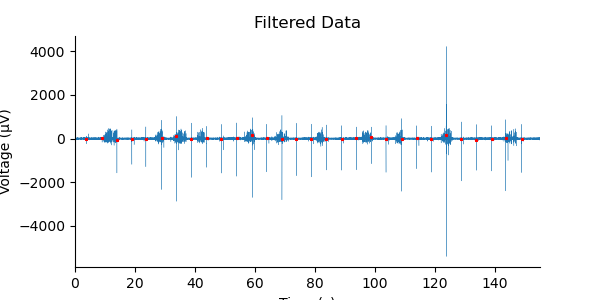

In [7]:
num, den = butter(2, [300, 7000], btype='bandpass', fs=sampling_frequency)
filtered_data = lfilter(num, den, data)

ns.visualization.plot_spikes(filtered_data, stimulus_idxs, sampling_time=sampling_time, title='Filtered Data')

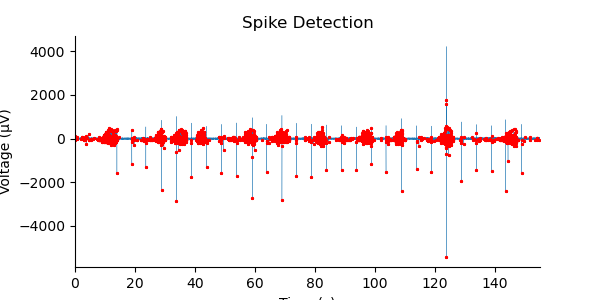

In [8]:
from scipy.stats import median_abs_deviation
threshold = 5*1.4824*median_abs_deviation(filtered_data)
spikes_idxs, _ = ns.spikes.hard_threshold_local_maxima(filtered_data, threshold, 0.001, use_abs=True, sampling_time=sampling_time)

ns.visualization.plot_spikes(filtered_data, spikes_idxs, sampling_time=sampling_time, title='Spike Detection')

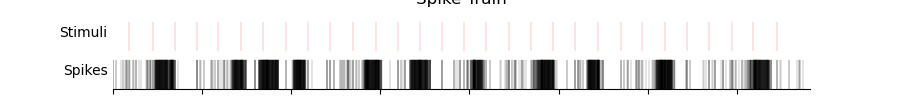

In [9]:
ns.visualization.plot_spike_train([spikes_idxs, stimulus_idxs], channel_labels=['Spikes', 'Stimuli'], color=['#000000', '#FF0000'], linewidth=0.15, sampling_time=sampling_time, figsize=(9, 1), dpi=100, ylabel='')